# Imports

In [65]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score

# Load the data

In [2]:
# Load the data
df = pd.read_csv('data/kc_housing_modifed.csv')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,1100000,2,1.75,2050,11900,1.0,0,2050,0,1950,0,98004
1,430000,3,1.50,1690,9708,1.5,0,1690,0,1954,0,98006
2,2150000,3,2.75,3470,9610,3.0,1,3470,0,1989,2000,98034
3,336000,4,2.50,2530,8169,2.0,0,2530,0,1993,0,98003
4,649500,3,3.00,3730,383328,1.5,0,2230,1500,1990,0,98038


# EDA

In [3]:
# Zip code is categorical
df['zipcode'] = df['zipcode'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          5000 non-null   int64  
 1   bedrooms       5000 non-null   int64  
 2   bathrooms      5000 non-null   float64
 3   sqft_living    5000 non-null   int64  
 4   sqft_lot       5000 non-null   int64  
 5   floors         5000 non-null   float64
 6   waterfront     5000 non-null   int64  
 7   sqft_above     5000 non-null   int64  
 8   sqft_basement  5000 non-null   int64  
 9   yr_built       5000 non-null   int64  
 10  yr_renovated   5000 non-null   int64  
 11  zipcode        5000 non-null   object 
dtypes: float64(2), int64(9), object(1)
memory usage: 468.9+ KB


In [4]:
# Check for missing values
df.isna().sum().sum()

0

In [5]:
# Get a list of numeric features for a pairwise plot
num_selector = make_column_selector(dtype_include = 'number')
cols = num_selector(df.drop(columns = 'price'))
len(cols)

10

In [6]:
# Setup up keywords (Is that what 'kws' means?) for seaborn
plot_kws = dict(line_kws = {'color': 'red', 'ls': '--'},
                scatter_kws = {'edgecolor': 'white', 'lw': 1})

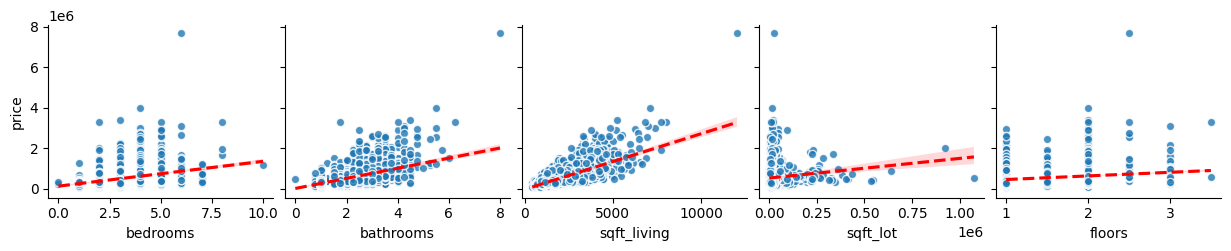

In [7]:
sns.pairplot(df, y_vars = 'price', 
             x_vars = cols[:5], 
             kind = 'reg',
             plot_kws = plot_kws);

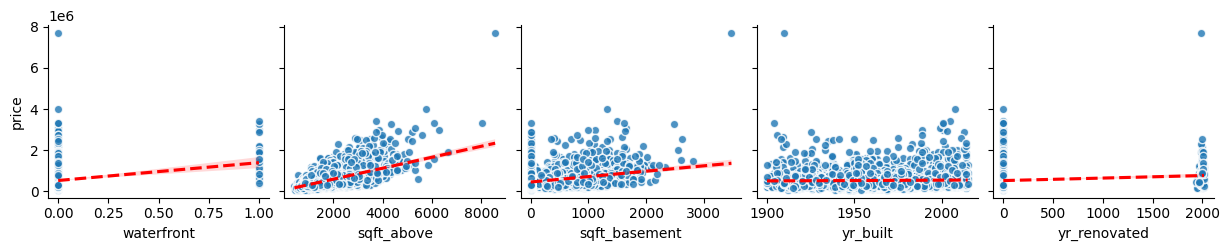

In [8]:
sns.pairplot(df, y_vars = 'price',
             x_vars = cols[5:], 
             kind = 'reg',
             plot_kws = plot_kws);

In [9]:
# sqft_loft and yr_built don't seem to be linearaly correlated with the target
df.drop(columns = ['sqft_lot', 'yr_built'], inplace = True)

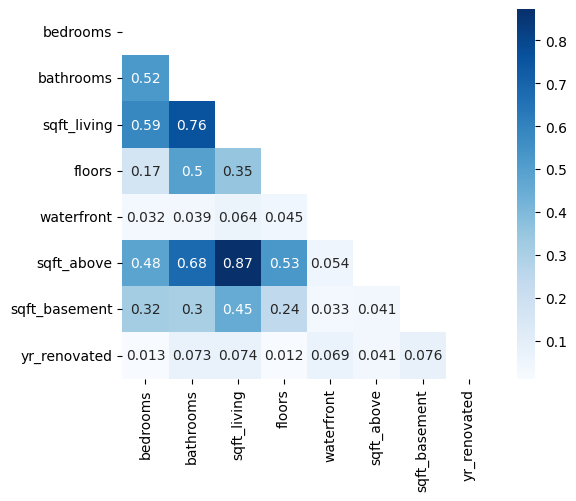

In [10]:
# Check for multicolinearity
corr = df.drop(columns = 'price').corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = True, cmap = 'Blues', annot = True, mask = mask);

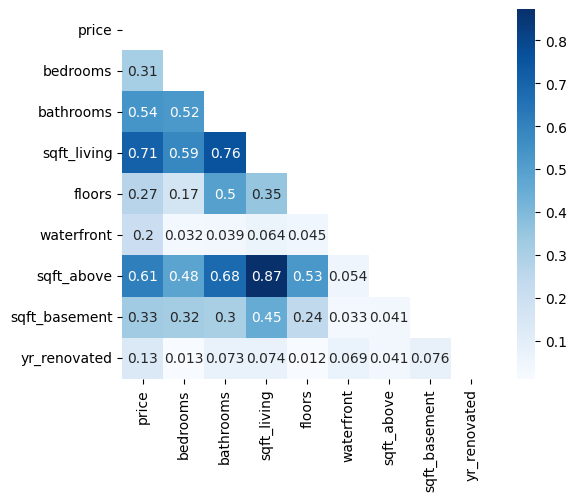

In [11]:
# Add price back to the features
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = True, cmap = 'Blues', annot = True, mask = mask);

In [12]:
# sqft_living and sqft_above are linearly correlated. sqft_above has the weaker
# correlation with price so we drop it.
df.drop(columns = 'sqft_above', inplace = True)

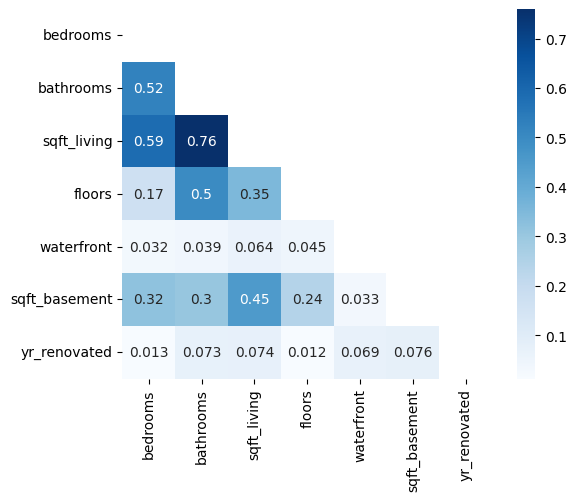

In [13]:
# Check for multicolinearity again
corr = df.drop(columns = 'price').corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, square = True, cmap = 'Blues', annot = True, mask = mask);

# Linear regression

In [14]:
# Set the features and target
X = df.drop(columns = 'price').copy()
y = df['price'].copy()

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)
X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode
1344,3,1.75,1850,1.0,0,0,0,98045
1282,3,2.25,1870,1.0,0,430,0,98011
681,3,1.75,1750,1.5,0,520,0,98117
3851,3,1.00,1170,1.0,0,0,0,98125
3564,2,1.50,901,3.0,0,0,0,98115


In [16]:
# Get the categorical columns
cat_selector = make_column_selector(dtype_include = 'object')
cat_cols = cat_selector(X_train)
cat_cols

['zipcode']

In [17]:
# Get the numeric columns
num_selector = make_column_selector(dtype_include = 'number')
num_cols = num_selector(X_train)
num_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'sqft_basement',
 'yr_renovated']

In [18]:
# Make pipelines
cat_pipe = make_pipeline(OneHotEncoder(handle_unknown = 'ignore',
                                       sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

In [19]:
# Make the preprocessor
preprocessor = make_column_transformer((num_pipe, num_cols),
                                       (cat_pipe, cat_cols),
                                       remainder = 'passthrough')

In [20]:
# Train the model
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['bedrooms', 'bathrooms', 'sqft_living',
                                  'floors', 'waterfront', 'sqft_basement',
                                  'yr_renovated']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['zipcode'])])

In [21]:
# Create a list of final features and add the numeric column names
final_features = []
final_features.extend(num_cols)

In [22]:
# Get the categorical feature names
cat_features = preprocessor.named_transformers_['pipeline-2'][0].\
get_feature_names_out(cat_cols)
final_features.extend(cat_features)

In [23]:
# Transform the X vars
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns = final_features,
                          index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns = final_features,
                         index = X_test.index)
X_train_df.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode_98001,zipcode_98002,zipcode_98003,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
1344,3.0,1.75,1850.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1282,3.0,2.25,1870.0,1.0,0.0,430.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
681,3.0,1.75,1750.0,1.5,0.0,520.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3851,3.0,1.00,1170.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3564,2.0,1.50,901.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Add constants for statsmodels
X_train_df = sm.add_constant(X_train_df, prepend = False)
X_test_df = sm.add_constant(X_test_df, prepend = False)

In [25]:
# Construct the linear regression model
model = sm.OLS(y_train, X_train_df)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     170.6
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:30:20   Log-Likelihood:                -50424.
No. Observations:                3750   AIC:                         1.010e+05
Df Residuals:                    3673   BIC:                         1.015e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -4.194e+04   3959.240    -10.592      0.000   -4.97e+04   -3.42e+04
bathrooms      3.168e+04   6347.907      4.990      0.000    1.92e+04    4.41e+04
sqft_living     288.4923      5.697     50.637      0.000     277.322     299.663
floors         -6.66e+04   7513.859     -8.864      0.000   -8.13e+04   -5.19e+04
waterfront     6.611e+05   3.54e+04     18.696      0.000    5.92e+05     7.3e+05
sqft_basement  -102.3957      8.841    -11.582      0.000    -119.729     -85.063
yr_renovated     30.9270      7.048      4.388      0.000      17.109      44.745
zipcode_98001  -2.16e+05   2.23e+04     -9.671      0.000    -2.6e+05   -1.72e+05
zipcode_98002 -2.004e+05   2.88e+04     -6.953      0.000   -2.57e+05   -1.44e+05
zipcode_98003 -2.237e+05   2.26e+04     -9.918      0.000   -2.68e+05   -1.79e+05
zipcode_98004  4.738e+05   2.44e+04     19.425      0.000    4.26e+05    5.22e+05
zipcode_98005  1.204e+05   2.94e+04      4.099      0.000    6.28e+04    1.78e+05
zipcode_98006  1.111e+05   1.78e+04      6.249      0.000    7.63e+04    1.46e+05
zipcode_98007  4.667e+04   3.17e+04      1.471      0.141   -1.55e+04    1.09e+05
zipcode_98008  6.144e+04   2.14e+04      2.866      0.004    1.94e+04    1.03e+05
zipcode_98010 -1.526e+05   4.83e+04     -3.163      0.002   -2.47e+05    -5.8e+04
zipcode_98011 -9.591e+04   2.73e+04     -3.518      0.000   -1.49e+05   -4.25e+04
zipcode_98014  -1.33e+05   4.19e+04     -3.178      0.001   -2.15e+05    -5.1e+04
zipcode_98019 -1.498e+05   3.07e+04     -4.880      0.000    -2.1e+05   -8.96e+04
zipcode_98022 -1.968e+05   2.76e+04     -7.125      0.000   -2.51e+05   -1.43e+05
zipcode_98023 -2.385e+05   1.71e+04    -13.911      0.000   -2.72e+05   -2.05e+05
zipcode_98024 -3.092e+04   5.29e+04     -0.585      0.559   -1.35e+05    7.27e+04
zipcode_98027 -5.737e+04   2.01e+04     -2.861      0.004   -9.67e+04   -1.81e+04
zipcode_98028 -8.227e+04   2.27e+04     -3.619      0.000   -1.27e+05   -3.77e+04
zipcode_98029  2.776e+04   2.31e+04      1.200      0.230   -1.76e+04    7.31e+04
zipcode_98030 -2.267e+05   2.77e+04     -8.197      0.000   -2.81e+05   -1.73e+05
zipcode_98031 -1.893e+05   2.63e+04     -7.208      0.000   -2.41e+05   -1.38e+05
zipcode_98032 -1.754e+05   4.19e+04     -4.190      0.000   -2.58e+05   -9.33e+04
zipcode_98033  1.271e+05   2.02e+04      6.281      0.000    8.74e+04    1.67e+05
zipcode_98034 -6005.3356   1.72e+04     -0.350      0.726   -3.97e+04    2.76e+04
zipcode_98038 -2.046e+05   1.71e+04    -11.986      0.000   -2.38e+05   -1.71e+05
zipcode_98039  1.095e+06   5.61e+04     19.510      0.000    9.85e+05    1.21e+06
zipcode_98040  3.844e+05   2.51e+04     15.341      0.000    3.35e+05    4.33e+05
zipcode_98042 -2.333e+05   1.82e+04    -12.790      0.000   -2.69e+05   -1.98e+05
zipcode_98045 -1.321e+05   2.66e+04     -4.962   

# Evaluate the model

In [26]:
# Get the residuals
resid = result.resid
resid

1344    -20242.467225
1282      1016.673278
681     -51423.211967
3851    103498.661493
3564    116338.934543
            ...      
168     267757.055395
1425     39466.221630
3784     -6159.756773
2847      2531.648669
4220      5887.033449
Length: 3750, dtype: float64

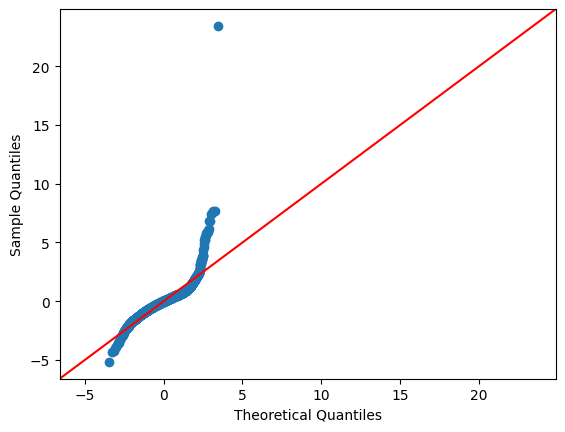

In [27]:
# Construct a Q-Q plot
sm.graphics.qqplot(resid, line = '45', fit = True);

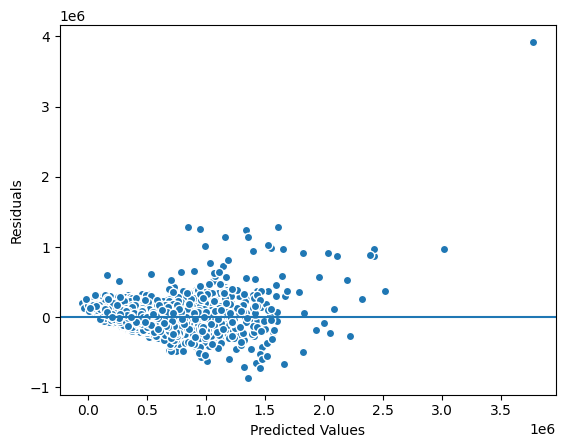

In [28]:
# Plot the residuals
y_pred = result.predict(X_train_df)
fig, ax = plt.subplots();
ax.scatter(y_pred, resid, ec = 'white', lw = 1);
ax.axhline(0);
ax.set(ylabel = 'Residuals', xlabel = 'Predicted Values');

In [62]:
# Define a function to evaluate OLS models
def evaluate_ols(result, X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a 
    statsmodel OLS regression."""
    
    # Make predictions
    y_pred = result.predict(X_train_df)
    
    # Save the residuls
    resid = y_train - y_pred
    
    # Setup the plots
    fig, axes = plt.subplots(ncols = 2, figsize = (13, 5));
    
    # Q-Q plot
    sm.graphics.qqplot(resid, line = '45', fit = True, ax = axes[0]);
    
    # Residual Plot
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor = 'white', lw = 1);
    ax.axhline(0, zorder = 0);
    ax.set(ylabel = 'Residuals', xlabel = 'Predicted Values');
    plt.tight_layout

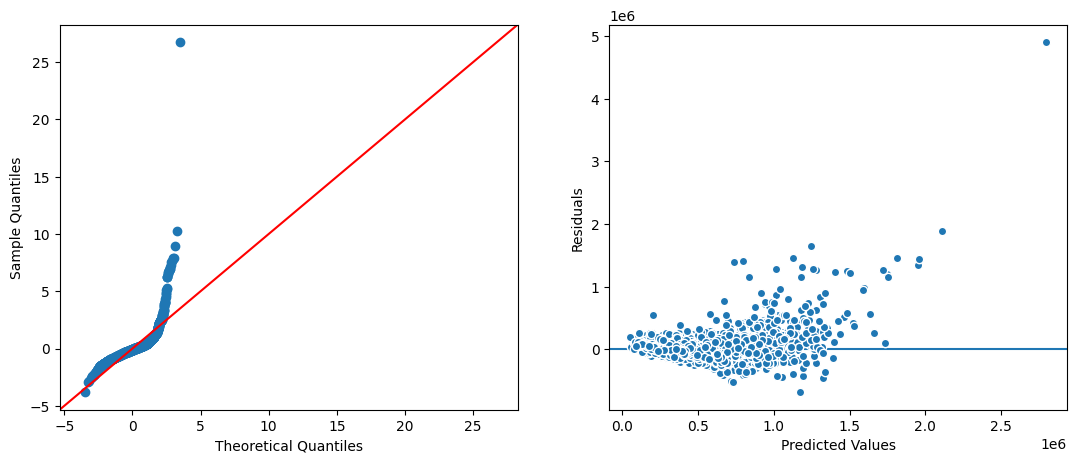

In [63]:
# Test the function
evaluate_ols(result, X_train_df, y_train)

In [31]:
# Normalize the target
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1, 1))
z_price

array([[-0.40517352],
       [-0.30686833],
       [-0.02613678],
       ...,
       [-0.76749839],
       [-0.91214746],
       [-0.46977408]])

In [32]:
# Convert the numpy array z_price to a pandas series
z_price = pd.Series(z_price.flatten(), index = y_train.index)
z_price

1344   -0.405174
1282   -0.306868
681    -0.026137
3851   -0.334956
3564   -0.278781
          ...   
168     1.982238
1425    0.156570
3784   -0.767498
2847   -0.912147
4220   -0.469774
Length: 3750, dtype: float64

In [33]:
# Save the indices of the outliers
idx_outliers = z_price > 3
idx_outliers

1344    False
1282    False
681     False
3851    False
3564    False
        ...  
168     False
1425    False
3784    False
2847    False
4220    False
Length: 3750, dtype: bool

In [34]:
# Determine how many outliers we have
idx_outliers.sum()

63

In [54]:
# Remove the outliers and save in a separate data frame
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

In [41]:
print(y_train_cln.min())
print(y_train_cln.max())

82000
1600000


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.3
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:31:57   Log-Likelihood:                -48210.
No. Observations:                3687   AIC:                         9.657e+04
Df Residuals:                    3610   BIC:                         9.705e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.972e+04   2814.752     -7.007

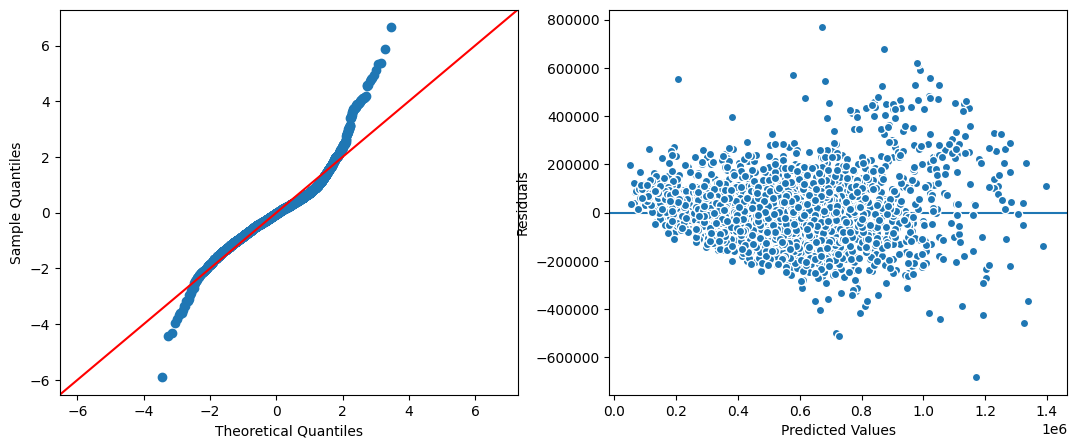

In [42]:
# Construct an OLS model 
model = sm.OLS(y_train_cln, X_train_cln)
result = model.fit()
print(result.summary())
evaluate_ols(result, X_train_cln)

In [45]:
# Check the p-values
p_vals = result.pvalues
# Filter p-values less than 0.05
p_vals[p_vals >= 0.05]

zipcode_98024    0.186877
zipcode_98027    0.336972
zipcode_98034    0.126808
zipcode_98053    0.141641
zipcode_98074    0.161004
zipcode_98077    0.263280
zipcode_98118    0.103993
zipcode_98125    0.324225
zipcode_98126    0.527918
dtype: float64

In [47]:
# Determine how many features relate to zipcode
zipcode_cols = [col for col in X_train_df.columns if col.startswith('zipcode')]
len(zipcode_cols)

70

In [49]:
# Determine how many zipcodes had p-values larger than 0.05
len(p_vals[p_vals >= 0.05])

9

In [60]:
# Remove outliers from the test data
z_test_price = scaler.transform(y_test.values.reshape(-1, 1))
z_test_price = pd.Series(z_test_price.flatten(), index = y_test.index)
idx_test_outliers = z_test_price > 3
y_test_cln = y_test[~idx_test_outliers]
X_test_cln = X_test_df[~idx_test_outliers]

0.7782153858847404


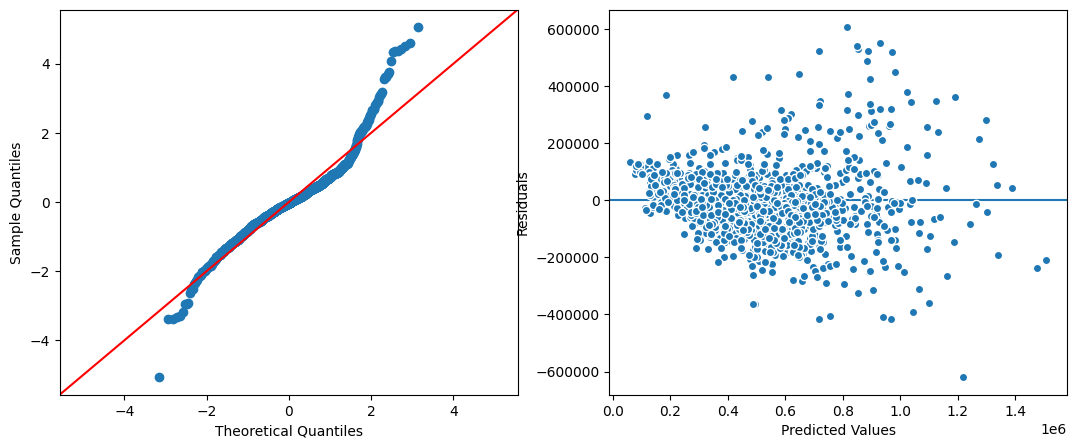

In [64]:
# Evaluate the model on the test data
r2_test = r2_score(y_test_cln, result.predict(X_test_cln))
print(r2_test)
evaluate_ols(result, X_test_cln, y_test_cln)

In [66]:
# Save the model
export = {'X_train': X_train_cln,
          'y_train': y_train_cln,
          'X_test': X_test_cln,
          'y_test': y_test_cln,
          'Outlier Scaler': scaler,
          'Column Transformer': preprocessor,
          'OLS Results': result}
joblib.dump(export, 'ols_results.joblib')

['ols_results.joblib']

In [68]:
# Loading a joblib
loaded_data = joblib.load('ols_results.joblib')
loaded_data.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'Outlier Scaler', 'Column Transformer', 'OLS Results'])